# Assignment 1: “Bag, not bag”

In [1]:
using NPZ
using Plots
using FiniteDifferences
using NamedArrays
using Random
using LinearAlgebra
using Statistics

In [2]:
# Download and extract the dataset. # Window 10 system need to do two steps. 1. remove the /tmp/ 2. hiding the third instruction
run(`curl -fsS http://udon.stacken.kth.se/\~ninjin/comp0090_assignment_1_data.tar.gz -o data.tar.gz`)
run(`tar -x -z -f data.tar.gz`)
#run(`del data.tar.gz`);

In [3]:
# Load Data # Window 10 system need to add NPZ to execute npzread
trainxs = npzread("comp0090_assignment_1_data/fashion-train-imgs.npz")
trainys = npzread("comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = npzread("comp0090_assignment_1_data/fashion-dev-imgs.npz")
devys   = npzread("comp0090_assignment_1_data/fashion-dev-labels.npz")
testxs  = npzread("comp0090_assignment_1_data/fashion-test-imgs.npz")
testys  = npzread("comp0090_assignment_1_data/fashion-test-labels.npz");

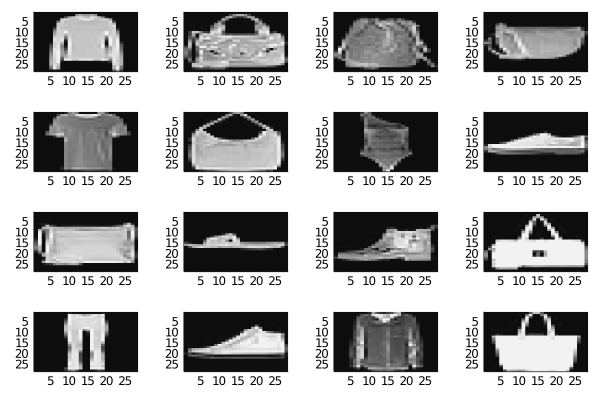

In [4]:
# Let us plot some random training samples. # Window 10 system need to add Plots to execute plot
plt = plot(layout=(4, 4))
for i in 1:4^2
    heatmap!(plt, trainxs[:, :, rand(1:size(trainxs, 3))]',
        subplot=i, yflip=true, color=:grays, colorbar = false)
end
plt

# Assignment 1.5: Model shootout 

## Question 1 (Define the perceptron)
## Question 2 (Use the Validation set to determine when to stop running)

### Calculate the accuracy

In [8]:
# Set the function and Check whether it is a bag or not
IsBag(w, b, x) = w'x + b >= 0
IsBag(zeros(784), 0, vec(trainxs[:, :, 1]))

function accuracy(w, b, y, x)
# w: [n,]
# b: scalar
# y: entire image label [m,]
# x: entire image set [3D]
    correct = 0
    for i in 1 : length(y)
        yhat = IsBag(w, b, vec(x[:, :, i])) 
        if yhat == y[i]
            correct = correct + 1
        end
    end
    
    correct / length(y) * 100
end

#accuracy(w, b, trainys, trainxs)

accuracy (generic function with 1 method)

### BaseLine Model

 84.543308 seconds (161.84 M allocations: 160.726 GiB, 10.99% gc time)


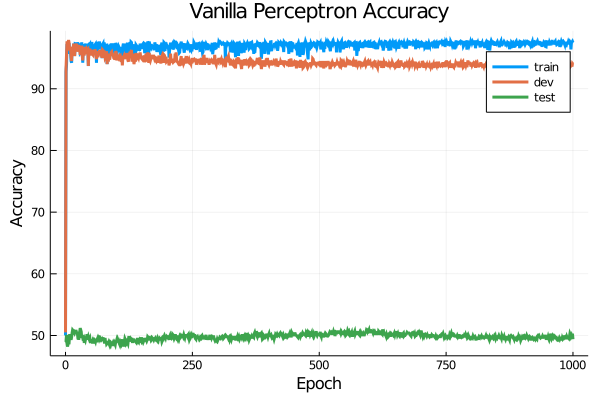

In [22]:
# Define the vector w dimension and scalar b
w = zeros(784)
b = 0.0

# Define the epoch and each dataset list 
epochs = 1000
train_accuracy = []
dev_accuracy = []
test_accuracy = []

# Initialize the vector w and scalar b
append!(train_accuracy, accuracy(w, b, trainys, trainxs))
append!(dev_accuracy, accuracy(w, b, devys, devxs))
append!(test_accuracy, accuracy(w, b, testys, testxs))

# Calculate the execution time
@time begin
    # Training the Data
    for iteration in 1 : epochs
        for i in 1 : length(trainys)
            x = vec(trainxs[:, :, i])
            y = trainys[i]
            IsBag(w, b, x) != y || continue
            # If correct, no any update, else improve the w and b
            if y == 1
                w = w .+ x
                b = b + 1
            else
                w = w .- x
                b = b - 1
            end
        end
        # Append the data into the list
        append!(train_accuracy, accuracy(w, b, trainys, trainxs))
        append!(dev_accuracy, accuracy(w, b, devys, devxs))
        append!(test_accuracy, accuracy(w, b, testys, testxs))
    end
end
# Plot the picture
plot(0 : 1000, [train_accuracy, dev_accuracy, test_accuracy], title = "Vanilla Perceptron Accuracy", label = ["train" "dev" "test"], lw = 3)
xlabel!("Epoch")
ylabel!("Accuracy")

Because of the plot result, we can notice that the validation set(dev) is still bumpy when execute one thousand iterations, hence, we can make a reasonable speculation that the validation set wouldn't converge and still be bumpy when the epoch is larger than 1000. Hence, if we want to determine when to stop training, we just try to make any reasonable assumptions. For instance, we can take the average every 100 epochs (1 -> 100, 101 -> 200, 201 -> 300, ..., 901 -> 1000) and obtain mean accuracy, when the previous one is larger than the latter one, we can stop to train data.

### Three Layer Perceptron

In [10]:
logistic(x) = 1 ./ (1 .+ exp.(-x))
logisticGradient(x) = logistic(x) .* (1 .- logistic(x))

logisticGradient (generic function with 1 method)

### Calculate the MultipleLayer accuracy

In [11]:
function MultipleAccuracy(trainxs, trainys, mlp)
    correct = 0
    loss_value = 0
    for i in 1 : length(trainys)
        loss_value = loss_value + loss(mlp, vec(trainxs[:, :, i]), trainys[i])
        if p(mlp, vec(trainxs[:, :, i])) == trainys[i]
            correct = correct + 1
        end
    end
    [correct / (length(trainys)) * 100, loss_value]
end

MultipleAccuracy (generic function with 1 method)

In [12]:
# trainxs[:, :, 1] # 1 represent which pictures [m, n, k] => m x n dimension => select number k picture

# Define the three layer perceptron structure
mutable struct ThreeLayerPerceptron
    Matrix_W1 ::Matrix{Float64}
    Matrix_W2 ::Matrix{Float64}
    Vector_w3 ::Vector{Float64}
    Vector_b1 ::Vector{Float64}
    Vector_b2 ::Vector{Float64}
    b3 ::Float64
end

ThreeLayerPerceptron(hids1, hids2) = ThreeLayerPerceptron(
        randn(hids1, 28 * 28)./100,
        randn(hids2, hids1)./100,
        randn(hids2)./100,
        zeros(hids1),
        zeros(hids2),
        0.0,
    )

mlp = ThreeLayerPerceptron(78, 78)

f(m::ThreeLayerPerceptron, x) = logistic(dot(m.Vector_w3, logistic(m.Matrix_W2 * logistic(m.Matrix_W1*x + m.Vector_b1) + m.Vector_b2)) + m.b3)
p(m::ThreeLayerPerceptron, x) = f(m, x) >= 0.5;

loss(m, x, y) = -log((1 - f(m, x))^(1 - y)) + -log(f(m, x)^y)

@show MultipleAccuracy(trainxs, trainys, mlp)

MultipleAccuracy(trainxs, trainys, mlp) = [50.0, 8328.733478909071]


2-element Array{Float64,1}:
   50.0
 8328.733478909071

In [13]:
# Convenience function.
import Base: zero
function zero(m::ThreeLayerPerceptron)
    Gradient_m = deepcopy(m)
    fill!(Gradient_m.Matrix_W1, 0)
    fill!(Gradient_m.Matrix_W2, 0)
    fill!(Gradient_m.Vector_w3, 0)
    fill!(Gradient_m.Vector_b1, 0)
    fill!(Gradient_m.Vector_b2, 0)
    Gradient_m.b3 = 0
    Gradient_m
end

IsDifferential(m, x, y) = Differential(zero(m), m, x, y)

function Differential(Gradient_m, m, x, y)
    # f(m::ThreeLayerPerceptron, x) = logistic(dot(m.Vector_w3, logistic(m.Matrix_W2*(m.Matrix_W1*x + m.Vector_b1) + m.Vector_b2) + m.b3))

    # Forward pass
    hids1 = logistic.(m.Matrix_W1*x + m.Vector_b1)
    hids2 = logistic.(m.Matrix_W2*hids1 + m.Vector_b2)
    hids3 = dot(m.Vector_w3, hids2) + m.b3
    IsDifferential_y = logistic(hids3)
    
    # Backwards pass
    error3 = IsDifferential_y - y
    Gradient_m.b3 = Gradient_m.b3 + error3
    Gradient_m.Vector_w3[:] = Gradient_m.Vector_w3[:] + error3 .* hids2
    
    error2 = 1 .- hids2
    Gradient_m.Vector_b2 = Gradient_m.Vector_b2 + hids2 .* error2 .* m.Vector_w3 .* error3
    for i in 1 : size(Gradient_m.Matrix_W2, 2)
        Gradient_m.Matrix_W2[:, i] = Gradient_m.Matrix_W2[:, i] + hids2 .* error2 .* m.Vector_w3 .* error3 * hids1[i]
    end
    
    error1 = 1 .- hids1
    Gradient_m.Vector_b1 = Gradient_m.Vector_b1 + (hids1 .* error1) .* (transpose(m.Matrix_W2) * Gradient_m.Vector_b2)
    for i in 1 : size(Gradient_m.Matrix_W1, 2)
        Gradient_m.Matrix_W1[:, i] = Gradient_m.Matrix_W1[:, i] + Gradient_m.Vector_b1 * x[i]
    end

    Gradient_m
end;

### Gradient Checking f′(x) = [f(x + 1/2ϵ) − f(x − 1/2ϵ)] / ϵ 

In [14]:
# Convenience functions

# Store parameter into vector
function flatten(m::ThreeLayerPerceptron)
    ToFlatten = (m.Matrix_W1, m.Matrix_W2, m.Vector_w3, m.Vector_b1, m.Vector_b2, [m.b3])
    vector = zeros(sum(length(x) for x in ToFlatten))
    offset = 1
    for parameter in ToFlatten
        vector[offset : offset + length(parameter) - 1] = parameter
        offset = offset + length(parameter)
    end
    vector
end

function Notflatten(m::ThreeLayerPerceptron, vector)
    ToFlatten = (m.Matrix_W1, m.Matrix_W2, m.Vector_w3, m.Vector_b1, m.Vector_b2, [m.b3])
    offset = 1
    for parameter in (m.Matrix_W1, m.Matrix_W2, m.Vector_w3, m.Vector_b1, m.Vector_b2)
        parameter[:] = vector[offset : offset + length(parameter) - 1]
        offset = offset + length(parameter)
    end
    m.b3 = vector[end]
    m
end

Notflatten (generic function with 1 method)

In [15]:
fdIsDifferential(m, x, y) = fdIsDifferential!(zero(m), m, x, y)
function fdIsDifferential!(Gradient_m, m, x, y)
    epsilon = 0.000001
    vector_m = flatten(m)
    vector_gradient_m = flatten(Gradient_m)
    for i in eachindex(vector_m)
        wi = vector_m[i]
        vector_m[i] = vector[m] + epsilon/2
        r = loss(Notflatten!(zero(m), vector_m), x, y)
        vector_m[i] = wi
        vector_m[i] = vector_m[i] - epsilon/2
        l = loss(Notflatten!(zero(m), vector_m), x, y)
        vector_gradient_m[i] = (r - l)/epsilon
        vector_m[i] = wi
    end
    Notflatten!(Gradient_m, vector_gradient_m)
end;

### Training Data

i = 1
trainacc = MultipleAccuracy(trainxs, trainys, mlp) = [50.0, 8321.96184833618]
i = 1
validacc = MultipleAccuracy(devxs, devys, mlp) = [50.5, 693.2330642318775]
i = 1
testacc = MultipleAccuracy(testxs, testys, mlp) = [49.2, 693.9162835025747]
i = 2
trainacc = MultipleAccuracy(trainxs, trainys, mlp) = [50.0, 8342.15866269589]
i = 2
validacc = MultipleAccuracy(devxs, devys, mlp) = [49.5, 695.8172973730913]
i = 2
testacc = MultipleAccuracy(testxs, testys, mlp) = [50.8, 694.1539259498555]
i = 3
trainacc = MultipleAccuracy(trainxs, trainys, mlp) = [50.0, 8459.63644892445]
i = 3
validacc = MultipleAccuracy(devxs, devys, mlp) = [50.5, 703.4278949639374]
i = 3
testacc = MultipleAccuracy(testxs, testys, mlp) = [49.2, 707.4366042913955]
i = 4
trainacc = MultipleAccuracy(trainxs, trainys, mlp) = [50.0, 9114.664190375908]
i = 4
validacc = MultipleAccuracy(devxs, devys, mlp) = [49.5, 763.2412593642766]
i = 4
testacc = MultipleAccuracy(testxs, testys, mlp) = [50.8, 753.6201773809279]
i = 5
train

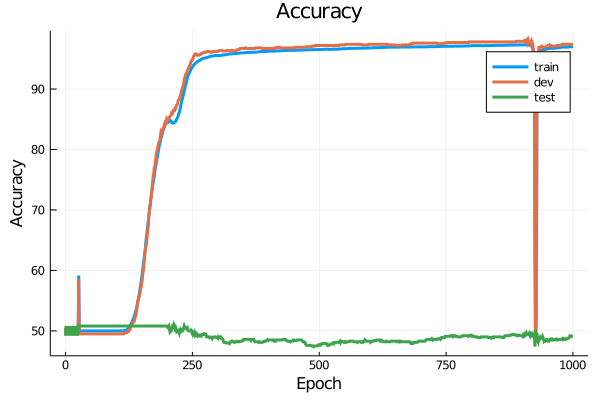

In [16]:
#batchsize = 8
learningrate = 0.65
#momentumcoefficient = 0.9
acc = []
loss_data = [];
accva = [];
loss_data_val = [];
acctest = [];
loss_data_test = [];

# train_accuracy = []
# dev_accuracy = []
# test_accuracy = []

# # Set the first element of the list
# append!(train_accuracy, (0, 0))
# append!(dev_accuracy, (0, 0))
# append!(test_accuracy, (0, 0))

# Calculate the execution time
@time begin
    let mlp = ThreeLayerPerceptron(80, 80)    
        epochs = 1001
        bestm = deepcopy(mlp)
        bestacc = 0.0
        bestaccv = 0.0

        for i in 1 : epochs
            Gradient_m = deepcopy(mlp)
            fill!(Gradient_m.Matrix_W1, 0)
            fill!(Gradient_m.Matrix_W2, 0)
            fill!(Gradient_m.Vector_w3, 0)
            fill!(Gradient_m.Vector_b1, 0)
            fill!(Gradient_m.Vector_b2, 0)
            Gradient_m.b3 = 0

            for s in 1 : length(trainys)
                Gradient_Value = IsDifferential(mlp, vec(trainxs[:, :, s]), trainys[s])
                Gradient_m.Matrix_W1 = Gradient_m.Matrix_W1 .- Gradient_Value.Matrix_W1
                Gradient_m.Matrix_W2 = Gradient_m.Matrix_W2 .- Gradient_Value.Matrix_W2
                Gradient_m.Vector_w3 = Gradient_m.Vector_w3 .- Gradient_Value.Vector_w3
                Gradient_m.Vector_b1 = Gradient_m.Vector_b1 .- Gradient_Value.Vector_b1
                Gradient_m.Vector_b2 = Gradient_m.Vector_b2 .- Gradient_Value.Vector_b2
                Gradient_m.b3 = Gradient_m.b3 - Gradient_Value.b3
            end

            Gradient_m.Matrix_W1 = Gradient_m.Matrix_W1 ./ length(trainys)
            Gradient_m.Matrix_W2 = Gradient_m.Matrix_W2 ./ length(trainys)
            Gradient_m.Vector_w3 = Gradient_m.Vector_w3 ./ length(trainys)
            Gradient_m.Vector_b1 = Gradient_m.Vector_b1 ./ length(trainys)
            Gradient_m.Vector_b2 = Gradient_m.Vector_b2 ./ length(trainys)
            Gradient_m.b3 = Gradient_m.b3 / length(trainys)

            mlp.Matrix_W1 = mlp.Matrix_W1 .+ Gradient_m.Matrix_W1 .* learningrate
            mlp.Matrix_W2 = mlp.Matrix_W2 .+ Gradient_m.Matrix_W2 .* learningrate
            mlp.Vector_w3 = mlp.Vector_w3 .+ Gradient_m.Vector_w3 .* learningrate
            mlp.Vector_b1 = mlp.Vector_b1 .+ Gradient_m.Vector_b1 .* learningrate
            mlp.Vector_b2 = mlp.Vector_b2 .+ Gradient_m.Vector_b2 .* learningrate
            mlp.b3 = mlp.b3 + Gradient_m.b3 * learningrate

            @show i trainacc = MultipleAccuracy(trainxs, trainys, mlp)
            @show i validacc = MultipleAccuracy(devxs , devys ,mlp)
            @show i testacc = MultipleAccuracy(testxs, testys, mlp) 
            
            # Append accuracy and loss into the array
            append!(acc ,trainacc[1])
            append!(loss_data ,trainacc[2])
            
            append!(accva ,validacc[1])
            append!(loss_data_val ,validacc[2])
            
            append!(acctest ,testacc[1])
            append!(loss_data_test ,testacc[2])
            

            trainacc[1] > bestacc  ||  continue
            bestm = deepcopy
            bestacc = trainacc[1]
            bestaccv = validacc[1]

        end
        @show bestacc
        @show bestaccv
        
        @show acc
        @show loss_data
        
        @show accva
        @show loss_data_val
        
        @show acctest
        @show loss_data_test
    end
end

# Plot the picture
# Accuracy
plot(0 : 1000, [acc[1 : 1001], accva[1 : 1001], acctest[1 : 1001]], title = "Accuracy", label = ["train" "dev" "test"], lw = 3)
xlabel!("Epoch")
ylabel!("Accuracy")

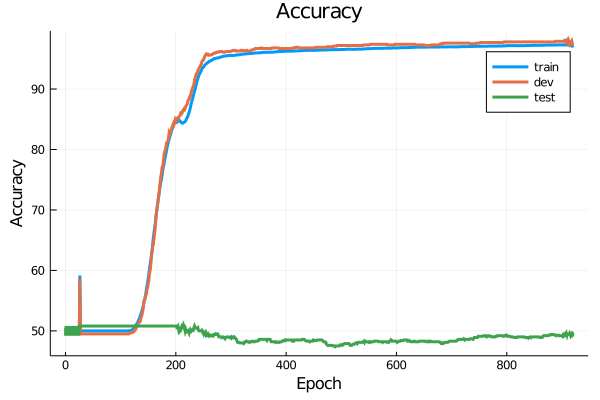

In [21]:
# Plot the picture
# Accuracy
plot(0 : 920, [acc[1 : 921], accva[1 : 921], acctest[1 : 921]], title = "Accuracy", label = ["train" "dev" "test"], lw = 3)
xlabel!("Epoch")
ylabel!("Accuracy")

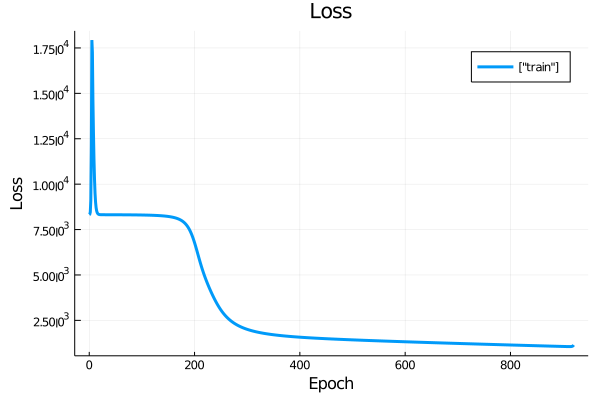

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [27]:
# Plot the picture
# Accuracy
plot(0 : 920, loss_data[1 : 921], title = "Loss", label = ["train"], lw = 3)
xlabel!("Epoch")
ylabel!("Loss")

## Question 3 
## Consider the models we have covered so far and make a reasonable attempt to outperform the baseline model on the validation set.
## Question 4 
## Briefly describe in one or three paragraphs how you approached the task and what your final best model is, also listing its hyperparameters.

In order to select the best model we have covered so far, we use the above models and define the same epochs, and time to train data, observe and compare the each models' efficiency. Finally, we choose the fourth model to be our best model in this assignment, some reasons illustrating my perspective will be shed light on as follows.

Parameter: N / A

1. BaseLine Model: Because of the plot result, we can notice that the validation set(dev) is still bumpy when execute one thousand iterations, hence, we can make a reasonable speculation that the validation set wouldn't converge and still be bumpy when the epoch is larger than 1000. In addition, even though the BaseLine Model training and predicting efficiency are fast, and don't need to set an extra parameter in the model, it still have many disadvantages. Actually, this model is suitable to small size data, if the data are larger than this assignment, it may not obtain the higher accuracy. Moreover, it can't execute in non-linear situation and the model have higher probability to overfit. It is not a stable algorithm.

Parameter: Learning Rate: 0.3

2. Mean squared-loss logistic regression Model: We can use the MSE(Mean Square error) to evaluate the variation of the data. When the MSE become smaller than we can obtain the higher accuracy. In addition, the Mean squared-loss logistic regression Model is similar to BaseLine Model. It also can't execute in non-linear situation and it is suitable to small size data. In addition to the previous statements. According to the plot result, we can notice that the accuracy of Mean squared-loss logistic is smaller than other models, besides, it is also trapped in a local extreme. However, compared to BaseLine Model, when the epoch is at 1000, the Model can reach convergence. But, if we want to receive higher accuracy, we need to execute more iterations.

Parameter: Hidden1: 80, Hidden2: 80, Learning Rate: 0.65

3. Multiple Layer Model: In fact, Multiple Layer Model have many advantages, such as it can deal with non-linear question, have parallel processing and stronger learning capacities. Whereas, even though we obtain the high accuracy in this model, it still have many disadvantages. Firstly, it is pretty hard to define the correct hidden1, hidden2 and learning rate parameters. For the purpose of getting higher accuracy, we need to adjust different combinations. In addition, the Multiple Layer needs to take a long time to train data. When the hidden1, hidden2 parameters are too large, further to cause the learning efficiency be pretty slow. Third, sometimes the Multiple Layer Model will be trapped in a local extreme.    

Parameter: Learning Rate: 0.7, Batch Size: 512, Momentum Coefficient: 0.9

4. Hyper Parameter Model: In fact, we can't know that which kinds of parameters are have more impact on the neural network, as a result, we use the random method to receive more parameters and take them to test model to improve efficiency and it doesn't need to take extra time to adjust parameters. According to plot result, even though the result have a little bumpy when the epoch is at 1000, however, it can receive the highest accuracy and smallest time consuming compared with other models. Therefore, we select this model to be our "best" model that we have covered so far.

## Question 5 
## Provide a plot of the square loss on the training set for each epoch.
## Question 6 
## Provide a plot of the accuracy on the training set for each epoch.
## Question 7
## Provide the accuracy on the training and validation set, for the epoch on which you obtain your highest accuracy on the validation set.

## 我會選最後一個model 到時候直接貼圖片在overleaf上面